# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 350

---

## Import data

This code is provided for you. Some columns with network and score-related data are dropped.

The remaining columns will be `#AUTHID`, `STATUS`, `cEXT`, `cNEU`, `cAGR`, `cCON`, `cOPN`, and `DATE`:

| Variable name | Description                                                                      |
|---------------|----------------------------------------------------------------------------------|
| `#AUTHID`     | Author ID code, unique per user                                                  |
| `STATUS`      | Text of a Facebook status                                                        |
| `cEXT`        | Author extroversion category, `y` for above median and `n` for below median      |
| `cNEU`        | Author neuroticism category, `y` for above median and `n` for below median       |
| `cAGR`        | Author agreeableness category, `y` for above median and `n` for below median     |
| `cCON`        | Author conscientiousness category, `y` for above median and `n` for below median |
| `cOPN`        | Author openness category, `y` for above median and `n` for below median          |
| `DATE`        | Time stamp of original Facebook status                                           |


In [2]:
df = pd.read_csv('data/mypersonality.csv')
# df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv

dropcols = [
    # these are network-related columns:
    'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY',
    'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY',
    # these are score-related columns;
    # we will use the catgories instead:
    'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN'
]

df.drop(columns=dropcols, inplace=True)
df.head(3)

,#AUTHID,STATUS,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",n,y,n,n,y,06/15/09 01:15 PM


## Data cleaning

It's often more convenient to work with integers than strings. Convert the personality columns to 0 and 1, with 0 meaning 'below the median' and 1 meaning 'above the median.'

In [3]:
# answers will vary - many ways to set this up:

In [4]:
convert_cats = {
    'n': 0,
    'y': 1
}

personality_cols = [col for col in df.columns if col.startswith('c')]

for col in personality_cols:
    df[col] = df[col].map(convert_cats)

df.head(3)

,#AUTHID,STATUS,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,0,1,0,0,1,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,0,1,0,0,1,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",0,1,0,0,1,06/15/09 01:15 PM


-----

## A first look at the dataset

In this section, check:

- How many observations are there in the dataset?
- How many unique `#AUTHID` codes are there?
- How many `y` and `n` values are in each of the personality category columns?

In [5]:
df.shape

(9916, 8)

In [6]:
len(set(df['#AUTHID']))

250

In [7]:
for col in ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']:
    print(df[col].value_counts())
    print()

0    5707
1    4209
Name: cEXT, dtype: int64

0    6199
1    3717
Name: cNEU, dtype: int64

1    5267
0    4649
Name: cAGR, dtype: int64

0    5360
1    4556
Name: cCON, dtype: int64

1    7369
0    2547
Name: cOPN, dtype: int64



In [8]:
# cols_to_plot = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

# for col in cols_to_plot:
#     df[col].value_counts().plot(kind='bar')
#     plt.title(f'Plot of {col} counts')
#     plt.show()


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status. Some personality types might be more long-winded than others!

### Create a new column called `status_char_length` that contains the character length of each status

> Note: You can do this in one line with `map`.

In [9]:
df['status_char_length'] = df['STATUS'].map(len)

### Create a new column called `status_word_count` that contains the number of words in each status

> Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [10]:
df['status_word_count'] = df['STATUS'].map(lambda x: len(x.split()))

---

## Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

### Show the five longest and five shortest statuses based off of `status_word_count`

In [11]:
df.sort_values(by='status_word_count', ascending=True)[['STATUS']].head()

,STATUS
8178,157
4170,"wed,."
2016,HOUSE!
956,Err:509
4177,confused


In [12]:
df.sort_values(by='status_word_count', ascending=False)[['STATUS']].head()

,STATUS
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can..."
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost ..."
5208,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age ..."
7976,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his l..."
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is p..."


---

## Investigating distribution of post lengths

We've now seen some of the shortest and longest posts in the dataset. But how common are short posts, and how common are long posts? 

Use visuals to show the distributions of post lengths.

> Note: There are multiple different types of visualizations you could use for this, and you could investigate this by looking at `status_word_count`, `status_char_length`, or both.

<AxesSubplot:xlabel='status_word_count'>

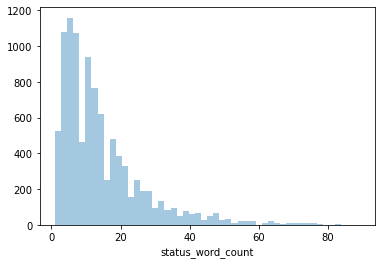

In [13]:
sns.distplot(df['status_word_count'], kde=False)

<AxesSubplot:xlabel='status_char_length'>

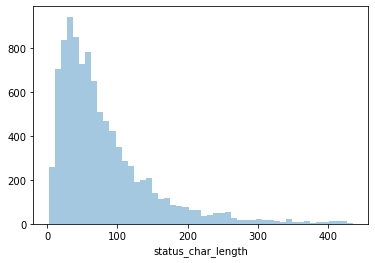

In [14]:
sns.distplot(df['status_char_length'], kde=False)

---

## Exploring personality categories and individual users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 2,000 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `1` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there? Do we have the same number of posts per user, or do we have some more posts by some users than others?

In [15]:
df['#AUTHID'].value_counts()

e6cdef6f475cce3023c5b715f8c9f110    223
6f2bebc01062eb8334dccba3e048fdb5    219
527ed53d2ba3a3bc417b8402d5b2f556    194
d7e500ad854a1b6ced39e53a525b8a6d    184
0737e4e4980f56c9fb1cb5743001c917    172
                                   ... 
22d1f7b24168528163c515b1c96a879c      1
5532642937eb3497a43e15dbb23a9d2d      1
19c6d69f9f5acc1a43d6ac498085e69f      1
c255a1cb2939ce6b4719a8a0cc085624      1
f6cb2eff458f065858363e86515beaab      1
Name: #AUTHID, Length: 250, dtype: int64

In [16]:
(223 + 219 + 194 + 184 + 172)/9916

0.100040338846309

---

### Create a new dataframe called `unique_users` that only contains the `#AUTHID` and personality category columns

If you do this correctly, it should have 250 rows and 6 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [17]:
personality_cols = [col for col in df.columns if col.startswith('c')]

In [18]:
unique_users = df.drop_duplicates(subset=['#AUTHID'])[['#AUTHID'] + personality_cols]

In [19]:
unique_users.head(3)

,#AUTHID,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,0,1,0,0,1
102,318bf822d4f2bd3920367560218619c0,1,1,0,1,0
171,ecbddbfe00e0f83cfdb802a7186061c7,1,0,1,0,1


### Using `unique_users`, investigate personality

For this section, perform EDA on just the unique users. Create 2-3 tables or visuals to investigate.

Here are some prompts to get you started:

- What proportion of above-median openness users also exhibit above-median extroversion vs. below-median extroversion? What about other pairs of personality traits?
- Do any two personality traits appear to be correlated?
- Are about equal numbers of users above median conscientiousness and below median conscientiousness, or is there an imbalanced split? What about the other personality traits?
- Are any users below-median across all five personality traits? How many?
- Are any users above-median all five personality traits? How many?

For each dataframe or plot you end up with, remember to provide interpretation in markdown as well.

In [20]:
# answers here will vary - invite students to share what they found when reviewing.

# due to the inherent nature of personality research, especially algorithmically identifying
# personality traits, don't expect students to find anything earth-shattering. there's no
# smoking gun or obvious relationship that they should find. be encouraging if students
# are hesitant to share their 'negative' results (i.e. "this plot doesn't really show anything,
# but...") -- sometimes there are not compelling relationships in the data!

In [21]:
unique_users.describe()

,cEXT,cNEU,cAGR,cCON,cOPN
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.384000,0.396000,0.536000,0.520000,0.704000
std,0.487334,0.490045,0.499703,0.500602,0.457407
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
unique_users.groupby('cOPN').mean()

,cEXT,cNEU,cAGR,cCON
cOPN,,,,
0,0.324324,0.418919,0.378378,0.513514
1,0.409091,0.386364,0.602273,0.522727


Text(0.5, 1.0, 'High and low personality traits based on high and low openness')

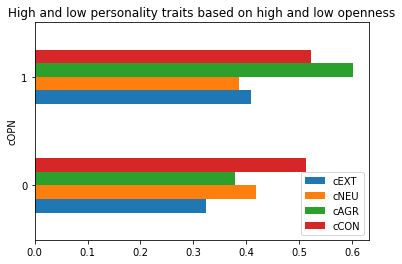

In [23]:
unique_users.groupby('cOPN').mean().plot(kind='barh')
plt.title('High and low personality traits based on high and low openness')

In [24]:
unique_users.corr()

,cEXT,cNEU,cAGR,cCON,cOPN
cEXT,1.000000,-0.269335,0.091429,0.182399,0.079561
cNEU,-0.269335,1.000000,-0.312656,-0.237050,-0.030387
cAGR,0.091429,-0.312656,1.000000,0.085410,0.204943
cCON,0.182399,-0.237050,0.085410,1.000000,0.008419
cOPN,0.079561,-0.030387,0.204943,0.008419,1.000000


In [25]:
unique_users['cOPN'].value_counts()

1    176
0     74
Name: cOPN, dtype: int64

In [26]:
unique_users['cAGR'].value_counts()

1    134
0    116
Name: cAGR, dtype: int64

## Plots vs. Tables

(Short answer.) Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics. You can provide your answer using sentences or bullet points.

---

## Exploring status length and word count based on personality

### Using `groupby()`, find the mean status length and status word count for posts by users in the above-median and below-median categories of each of the personality traits

> Note: Using `groupby()` five separate times is the easiest way to do this.

In [27]:
df.groupby(['cOPN']).mean()[['status_char_length', 'status_word_count']]

,status_char_length,status_word_count
cOPN,,
0,85.686298,15.450726
1,78.905143,14.205184


In [28]:
df.groupby(['cCON']).mean()[['status_char_length', 'status_word_count']]

,status_char_length,status_word_count
cCON,,
0,81.920149,14.709515
1,79.149034,14.308165


In [29]:
df.groupby(['cEXT']).mean()[['status_char_length', 'status_word_count']]

,status_char_length,status_word_count
cEXT,,
0,79.866655,14.394428
1,81.704918,14.702305


In [30]:
df.groupby(['cAGR']).mean()[['status_char_length', 'status_word_count']]

,status_char_length,status_word_count
cAGR,,
0,80.976769,14.616692
1,80.355800,14.444276


In [31]:
df.groupby(['cNEU']).mean()[['status_char_length', 'status_word_count']]

,status_char_length,status_word_count
cNEU,,
0,80.852396,14.548314
1,80.304278,14.486414


### Distribution of post length for above- and below-median personality traits

Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Visualize the distribution of status word counts of posts for users who are both above-median and below-median on that trait.

> Note: This can be done several ways -- using seaborn or matplotlib, and as overlapping histograms or as side-by-side or stacked histograms.

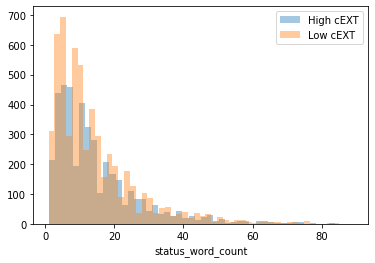

In [32]:
sns.distplot(df[df['cEXT'] == 1]['status_word_count'], kde=False, label='High cEXT')
sns.distplot(df[df['cEXT'] == 0]['status_word_count'], kde=False, label='Low cEXT')
plt.legend();

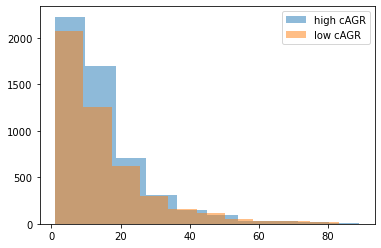

In [33]:
plt.hist(df[df['cAGR'] == 1]['status_word_count'], label='high cAGR', alpha=.5)
plt.hist(df[df['cAGR'] == 0]['status_word_count'], label='low cAGR', alpha=.5)
plt.legend()

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [34]:
cv = CountVectorizer(stop_words='english', min_df=3)
cv.fit(df['STATUS'])

status_cv = cv.transform(df['STATUS'])
status_df = pd.DataFrame(status_cv.todense(), columns=cv.get_feature_names())

### Show the 15 most common words

In [35]:
status_df.sum().sort_values(ascending=False).head(15)

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

<AxesSubplot:>

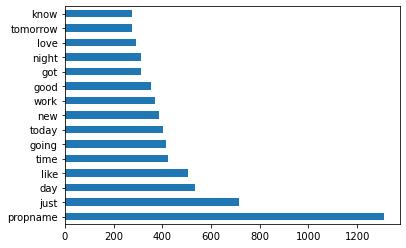

In [36]:
status_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show 10 statuses in the dataset that contain `propname`:

In [37]:
[status for status in df['STATUS'] if 'propname' in status.lower()][:10]

['saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.',
 'is tired. *PROPNAME*, let me go to sleep pl0x.',
 'has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.',
 'has a serious crush on *PROPNAME*. <3',
 'Mondays are the new thursdays- anthony bourdain + *PROPNAME*  = forgetting your financial troubles',
 "is *PROPNAME*'s bestbian",
 'is in love with *PROPNAME*.',
 'is in love. With *PROPNAME*.',
 "Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt",
 'ATTENTION EVERYONE!!! Vote for the short "AFTER HOURS" to support *PROPNAME* - our local Michigan talent and a wonderful pe

#### Provide a short explanation of what you believe `propname` to be:

> Note: The attached PDF also contains an explanation.

-----

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

### Create a new dataframe with the vectorized text _and_ the personality category columns

> Note: One way to do this is by using [`pd.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html).

In [38]:
text_and_scores = pd.concat([status_df, df[personality_cols]], axis=1)

### Show the 25 most common words for statuses from high-cAGR users

In [39]:
text_and_scores[text_and_scores['cAGR'] == 1].drop(columns=personality_cols).sum().sort_values(ascending=False).head(25)

propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
know        157
got         157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
weekend     105
ll          103
dtype: int64

### Show the 25 most common words for statuses from low-cAGR users

In [40]:
text_and_scores[text_and_scores['cAGR'] == 0].drop(columns=personality_cols).sum().sort_values(ascending=False).head(25)

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
really      119
know        119
people      112
think       110
want        109
happy       107
week         98
dtype: int64

-----

### (BONUS) Most common bigrams:

This is a bonus section and not required.

Find the 10 most common bigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

In [41]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english')
cv_bigrams.fit(df['STATUS'])

bigrams_cv = cv_bigrams.transform(df['STATUS'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

bigrams_df.sum().sort_values(ascending=False).head(15)

propname propname    147
just got              55
new year              53
http www              46
merry christmas       44
looking forward       43
feel like             39
happy new             32
don know              31
birthday wishes       29
feels like            28
copy paste            25
don want              23
gainesville film      23
examiner com          23
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required.

Find the 10 most common trigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

In [42]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')
cv_trigrams.fit(df['STATUS'])

trigrams_cv = cv_trigrams.transform(df['STATUS'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

trigrams_df.sum().sort_values(ascending=False).head(15)

propname propname propname    54
gainesville film industry     23
www examiner com              23
http www examiner             23
24676 gainesville film        23
film industry examiner        23
happy new year                21
examiner com examiner         20
com examiner 24676            20
examiner 24676 gainesville    20
downtown comedy club          16
ha ha ha                      12
thanks birthday wishes        11
work 30 close                 10
copy paste status             10
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:

- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate.

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.